<a href="https://colab.research.google.com/github/alima002/prop/blob/main/prop_HF_vqe_active_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
!pip install pyscf

#imports

In [2]:
import pennylane as qml
from pyscf import gto, scf, tools
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

#User informations

In [3]:
#modifications that must be made by the user
geom = """
H 0.0  0.0  0.0
F 0.99456  0.0  0.0
"""
charge = 0
mult = 1
spin = 0
verbose=10
basis = "STO-3G"
Ang2Bohr = 1.8897259886

nelec = 10
active_space = True
active_electrons = 2
active_orbitals = 2

#HF tem 6 orbitais atomicos

#Functions

In [4]:
def C_2nd_quantization_order(Ca, Cb):
  N = Ca.shape[0]
  M = 2*Ca.shape[1]

  C = np.empty((N,M), dtype=Ca.dtype)

  C[:,0::2] = Ca
  C[:,1::2] = Cb

  return C

In [5]:
#Generating the JW transformation matrix

CREATION_FERMION_OP_TYPE = 0   #The creation operator 𝑎† is defined as (1/2)*(𝑋−𝑖𝑌).
ANNIHILATION_FERMION_OP_TYPE = 1  #The annihilation operator 𝑎 is defined as (1/2)*(𝑋+𝑖𝑌).


def pauli_string_fermion_operator(p, op_type):
  f = (2*op_type-1)*1j    # When op_type = 0 (creation), f = -i, else f = i

  Q_p = 0.5*(qml.PauliX(p) + f * qml.PauliY(p))  #linear combination of the Pauli operators X and Y, with the correct factor to represent the fermion operators

  if p == 0:
    return Q_p

  for i in range(p):
    Q_p = qml.PauliZ(i) @ Q_p  # Adds Z operators to preserve fermionic anticommutation rules.

  return Q_p


def pauli_string_excitation_operator(p, q):
  a_dagger_p = pauli_string_fermion_operator(p, CREATION_FERMION_OP_TYPE)
  a_q = pauli_string_fermion_operator(q, ANNIHILATION_FERMION_OP_TYPE)
  return a_dagger_p @ a_q


In [7]:
#The number of qubits here is calculated using all the orbital spins of the molecule, without considering active spaces

def build_rdm1_active(qubits, ref_hf, ref_active, active_orbitals):

    '''
    ref_hf: ON vector obtained with Hartree-Fock
    ref_active: ON vector obtained with VQE
    '''

    active_spin_orbitals = active_orbitals*2
    total_spin_orbitals = qubits

    #--------------- Indexes in the total system and in the active space----------------------------------------------
    #Create a list with the indices of the active spin-orbitals within the complete system.
    active_indices = list(range(total_spin_orbitals - active_spin_orbitals, total_spin_orbitals))

    active_map = {active_indices[i]: i for i in range(active_spin_orbitals)}  #e.g. {4:0, 5:1, 6:2, 7:3}

   # Build HF RDM1 (total system)
    Xs = [pauli_string_excitation_operator(q, p) for p in range(total_spin_orbitals) for q in range(total_spin_orbitals)]
    rdm1_hf = np.array([excitation_operator_expval_hf(ref_hf, X_qp) for X_qp in Xs]).reshape((total_spin_orbitals, total_spin_orbitals))

   # Build RDM1 from quantum circuit (active space)
    Xs_active = [pauli_string_excitation_operator(active_map[q], active_map[p])
                 for p in active_indices for q in active_indices]  # Mapping to active space
    rdm1_active = np.array([excitation_operator_expval_active(ref_active, X_qp) for X_qp in Xs_active])
    rdm1_active = rdm1_active.reshape((active_spin_orbitals, active_spin_orbitals))

    # Update HF RDM1 matrix with active space values
    for i, p in enumerate(active_indices):
        for j, q in enumerate(active_indices):
            rdm1_hf[p, q] = rdm1_active[i, j]

    return rdm1_hf

In [8]:
def rdm1_mo2ao(rdm1, C):
  return C @ rdm1 @ C.T

#rdm1 in atomic orbitals
def build_rdm1_ao(qubits, C):
  rdm1 = build_rdm1_active(qubits)
  return rdm1_mo2ao(rdm1, C)

#electron density with pennylane
def compute_electron_density_grid(rdm1, ao_vals):
  return np.einsum("ip,pq,iq->i", ao_vals, rdm1, ao_vals)

In [49]:
#grid
grid = np.linspace(-3.0, 3.0, 60).reshape(-1, 1)
grid = np.hstack([grid, np.zeros((grid.shape[0], 2))])
grid = np.array(grid) * Ang2Bohr

#Pyscf

In [9]:
from pyscf import gto, scf, ci
mol = gto.M(atom=geom, basis=basis, charge=charge, spin=spin, verbose=verbose)
mf = scf.HF(mol).run()
#wf = ci.CISD(mf).run() #
#wf.kernel()

myhf = mol.HF().run()

# For example, to include all electrons in the active space:
wf = myhf.CASSCF(2, 2).run()  # 2 orbitals (4 spins orbitais): 2 electrons (1 orbital) - 1 orbital desocupado


if isinstance(wf, scf.uhf.UHF):  # Path to UHF Class
    Ca, Cb = wf.mo_coeff  # UHF returns two arrays
else:
    Ca = wf.mo_coeff  # RHF or HF returns a single array
    Cb = Ca  # In RHF, the α and β orbitals are the same

S = mol.intor("int1e_ovlp")
I = Ca.T @ S @ Ca

System: uname_result(system='Linux', node='2fbbc82d9ffe', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024', machine='x86_64')  Threads 2
Python 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
numpy 1.26.4  scipy 1.14.1  h5py 3.12.1
Date: Wed Mar 12 13:37:13 2025
PySCF version 2.8.0
PySCF path  /usr/local/lib/python3.11/dist-packages/pyscf

[CONFIG] ARGPARSE = False
[CONFIG] DEBUG = False
[CONFIG] MAX_MEMORY = 4000
[CONFIG] TMPDIR = /tmp
[CONFIG] UNIT = angstrom
[CONFIG] VERBOSE = 3
[CONFIG] conf_file = None
[INPUT] verbose = 10
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   

In [13]:
C = C_2nd_quantization_order(Ca,Cb) # MO coeff. matrix
print(C)

[[-4.92201518e-03 -4.92201518e-03  1.42767083e-01  1.42767083e-01
  -5.45494901e-01 -5.45494901e-01  0.00000000e+00  0.00000000e+00
  -3.10881957e-19 -3.10881957e-19  1.02137772e+00  1.02137772e+00]
 [ 9.94790787e-01  9.94790787e-01 -2.52056906e-01 -2.52056906e-01
  -7.39881452e-02 -7.39881452e-02  0.00000000e+00  0.00000000e+00
   3.97763826e-19  3.97763826e-19  7.64282663e-02  7.64282663e-02]
 [ 2.19158130e-02  2.19158130e-02  9.56195439e-01  9.56195439e-01
   3.87030841e-01  3.87030841e-01  0.00000000e+00  0.00000000e+00
  -4.34887199e-18 -4.34887199e-18 -4.76041670e-01 -4.76041670e-01]
 [-2.40361262e-03 -2.40361262e-03 -6.69952538e-02 -6.69952538e-02
   6.94342908e-01  6.94342908e-01  0.00000000e+00  0.00000000e+00
  -8.96792872e-20 -8.96792872e-20  8.08833195e-01  8.08833195e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.

In [50]:
rdm1_pyscf = wf.make_rdm1()
print(rdm1_pyscf)


#If UHF or RHF is used, it is necessary sum the two matrices:
#rdm1_pyscf = np.sum(rdm1_pyscf, axis=0)
#print("Shape of rdm1_pyscf:", rdm1_pyscf.shape)

[[ 6.37317813e-01 -9.40399837e-04 -1.50076881e-01 -7.75537851e-01
   0.00000000e+00  5.64179979e-18]
 [-9.40399837e-04  2.11723898e+00 -4.95747377e-01 -7.36737535e-02
   0.00000000e+00  4.21613014e-19]
 [-1.50076881e-01 -4.95747377e-01  2.12946450e+00  4.08730235e-01
   0.00000000e+00 -2.62359524e-18]
 [-7.75537851e-01 -7.36737535e-02  4.08730235e-01  9.74074775e-01
   0.00000000e+00  4.46755804e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.00000000e+00  0.00000000e+00]
 [ 5.64179979e-18  4.21613014e-19 -2.62359524e-18  4.46755804e-18
   0.00000000e+00  1.99868185e+00]]


In [51]:
#----------electron density with pyscf----------------

#GTOs calculations
ao_vals_pyscf = gto.eval_gto(mol, "GTOval", grid)

#electron density
density_grid_pyscf = np.einsum("pi,ij,pj->p", ao_vals_pyscf, rdm1_pyscf, ao_vals_pyscf)
print(density_grid_pyscf)

[8.58370681e-08 1.76945185e-07 3.55772648e-07 6.97718985e-07
 1.33466454e-06 2.49039041e-06 4.53323095e-06 8.05146664e-06
 1.39580111e-05 2.36338310e-05 3.91285391e-05 6.34609546e-05
 1.01118897e-04 1.58972382e-04 2.48024382e-04 3.86775155e-04
 6.07519900e-04 9.67639592e-04 1.56865411e-03 2.58561177e-03
 4.30642212e-03 7.17379201e-03 1.18216443e-02 1.91567949e-02
 3.07638588e-02 5.02028836e-02 8.50584351e-02 1.45728732e-01
 2.32066080e-01 3.14049986e-01 3.49084563e-01 3.36741008e-01
 3.24152025e-01 3.57194827e-01 4.56045209e-01 6.19399640e-01
 8.29261039e-01 1.14285470e+00 6.53604975e+00 1.75172221e+02
 3.74888810e+01 2.31085305e+00 1.30613237e+00 9.34839024e-01
 5.80531406e-01 3.21032478e-01 1.62188706e-01 7.79756310e-02
 3.70037601e-02 1.75763796e-02 8.28237440e-03 3.79451558e-03
 1.65612274e-03 6.78055406e-04 2.57743584e-04 9.03092213e-05
 2.89818237e-05 8.45299440e-06 2.21531588e-06 5.12356578e-07]


#Pennylane

In [14]:
geom_data = geom.split()
symbols = tuple(geom_data[4*i] for i in range(len(geom_data)//4))
coordinates = tuple(geom_data[4*i+1:4*i+4] for i in range(len(geom_data)//4))
coordinates = np.array(coordinates, dtype=float).reshape((-1, 3)) * Ang2Bohr

# Set up the molecule object without active space specification
qml_mol = qml.qchem.Molecule(symbols, coordinates, charge=charge, mult=mult, basis_name=basis)

In [15]:
# Calculate the Hamiltonian, the hf_state, and the number of qubits whit Hartree-Fock
H_complet, qubits = qml.qchem.molecular_hamiltonian(qml_mol)

ref_hf = qml.qchem.hf_state(nelec, qubits)

In [16]:
# Calculate the Hamiltonian, the hf_state, and the number of qubits, specifying the active space
H_active, qubits_active = qml.qchem.molecular_hamiltonian(
    qml_mol, active_electrons=active_electrons, active_orbitals=active_orbitals)
if active_space:
    ref_active = qml.qchem.hf_state(active_electrons, qubits_active)
else:
    ref_active = qml.qchem.hf_state(nelec, qubits_active)

In [17]:
print(ref_hf)
print(ref_active)

[1 1 1 1 1 1 1 1 1 1 0 0]
[1 1 0 0]


In [33]:
dev = qml.device("default.qubit", wires=list(range(qubits)))

In [37]:
#X_pq whit HF state

@qml.qnode(dev)
def excitation_operator_expval_hf(ref_hf, X_pq):
  qml.BasisState(ref_hf, wires=range(qubits))
  return qml.expval(X_pq)

In [42]:
#X_pq with VQE

loaded_params = np.load("final_params_HF.npy")
expected_shape = qml.GateFabric.shape(n_layers=1, n_wires=qubits_active)
@qml.qnode(dev)
def excitation_operator_expval_active(ref_active, X_pq_active):
    qml.GateFabric(loaded_params, wires=list(range(qubits_active)), init_state=ref_active, include_pi=True)
    return qml.expval(X_pq_active)

In [43]:
rdm1 = build_rdm1_active(qubits=qubits, ref_hf=ref_hf, ref_active=ref_active, active_orbitals=active_orbitals)
print("RDM1 with VQE:")
print(rdm1)

/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1127: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


RDM1 with VQE:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

In [44]:
rdm1_ao = rdm1_mo2ao(rdm1, C) #convert to AO basis
print('rdm1 in atomic orbitals')
print(rdm1_ao)

rdm1 in atomic orbitals
[[ 6.37444269e-01 -9.30937343e-04 -1.50135819e-01 -7.75437710e-01
   0.00000000e+00  2.93522252e-21]
 [-9.30937343e-04  2.11723969e+00 -4.95751787e-01 -7.36662601e-02
   0.00000000e+00 -3.86372058e-22]
 [-1.50135819e-01 -4.95751787e-01  2.12949197e+00  4.08683562e-01
   0.00000000e+00  5.10012413e-21]
 [-7.75437710e-01 -7.36662601e-02  4.08683562e-01  9.74154077e-01
   0.00000000e+00  2.09914072e-21]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.00000000e+00  0.00000000e+00]
 [ 2.93522252e-21 -3.86372058e-22  5.10012413e-21  2.09914072e-21
   0.00000000e+00  1.99856064e+00]]


In [52]:
density_grid = compute_electron_density_grid(rdm1_ao, ao_vals_pyscf)
print(density_grid)

[8.58540998e-08 1.76980294e-07 3.55843240e-07 6.97857425e-07
 1.33492936e-06 2.49088455e-06 4.53413042e-06 8.05306418e-06
 1.39607806e-05 2.36385201e-05 3.91363019e-05 6.34735430e-05
 1.01138949e-04 1.59003888e-04 2.48073483e-04 3.86851569e-04
 6.07639508e-04 9.67829021e-04 1.56895850e-03 2.58610708e-03
 4.30723229e-03 7.17510904e-03 1.18237459e-02 1.91600630e-02
 3.07688505e-02 5.02105940e-02 8.50708359e-02 1.45748977e-01
 2.32096386e-01 3.14086562e-01 3.49116487e-01 3.36759035e-01
 3.24156810e-01 3.57194841e-01 4.56051175e-01 6.19421671e-01
 8.29307645e-01 1.14292379e+00 6.53609138e+00 1.75172243e+02
 3.74889255e+01 2.31089369e+00 1.30616103e+00 9.34856787e-01
 5.80542828e-01 3.21039178e-01 1.62192131e-01 7.79772491e-02
 3.70045255e-02 1.75767597e-02 8.28257177e-03 3.79461894e-03
 1.65617531e-03 6.78080741e-04 2.57755040e-04 9.03140764e-05
 2.89837605e-05 8.45372724e-06 2.21558152e-06 5.12449913e-07]


#Electron density

In [53]:
print('pyscf')
print(rdm1_pyscf)

print('pennylane')
print(rdm1_ao)

pyscf
[[ 6.37317813e-01 -9.40399837e-04 -1.50076881e-01 -7.75537851e-01
   0.00000000e+00  5.64179979e-18]
 [-9.40399837e-04  2.11723898e+00 -4.95747377e-01 -7.36737535e-02
   0.00000000e+00  4.21613014e-19]
 [-1.50076881e-01 -4.95747377e-01  2.12946450e+00  4.08730235e-01
   0.00000000e+00 -2.62359524e-18]
 [-7.75537851e-01 -7.36737535e-02  4.08730235e-01  9.74074775e-01
   0.00000000e+00  4.46755804e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.00000000e+00  0.00000000e+00]
 [ 5.64179979e-18  4.21613014e-19 -2.62359524e-18  4.46755804e-18
   0.00000000e+00  1.99868185e+00]]
pennylane
[[ 6.37444269e-01 -9.30937343e-04 -1.50135819e-01 -7.75437710e-01
   0.00000000e+00  2.93522252e-21]
 [-9.30937343e-04  2.11723969e+00 -4.95751787e-01 -7.36662601e-02
   0.00000000e+00 -3.86372058e-22]
 [-1.50135819e-01 -4.95751787e-01  2.12949197e+00  4.08683562e-01
   0.00000000e+00  5.10012413e-21]
 [-7.75437710e-01 -7.36662601e-02  4.08683562e-01  9.74154077e-01
   0.000

In [54]:
#Differences between electron density with pyscf and pennylane
difference = density_grid - density_grid_pyscf
print(difference)

[1.70316528e-11 3.51091776e-11 7.05918288e-11 1.38440238e-10
 2.64821788e-10 4.94138307e-10 8.99472165e-10 1.59754120e-09
 2.76945428e-09 4.68911169e-09 7.76281853e-09 1.25883309e-08
 2.00522586e-08 3.15062121e-08 4.91002986e-08 7.64136780e-08
 1.19608336e-07 1.89428430e-07 3.04397191e-07 4.95308531e-07
 8.10175606e-07 1.31702871e-06 2.10159433e-06 3.26812650e-06
 4.99170371e-06 7.71044083e-06 1.24008734e-05 2.02455287e-05
 3.03062392e-05 3.65761268e-05 3.19238380e-05 1.80266441e-05
 4.78499295e-06 1.37498257e-08 5.96566649e-06 2.20304655e-05
 4.66060974e-05 6.90912001e-05 4.16246593e-05 2.20906210e-05
 4.44526725e-05 4.06430959e-05 2.86615158e-05 1.77635351e-05
 1.14212710e-05 6.70049402e-06 3.42479483e-06 1.61803618e-06
 7.65367441e-07 3.80073056e-07 1.97368928e-07 1.03363232e-07
 5.25631181e-08 2.53352755e-08 1.14562482e-08 4.85508953e-09
 1.93680227e-09 7.32841792e-10 2.65636601e-10 9.33353569e-11]


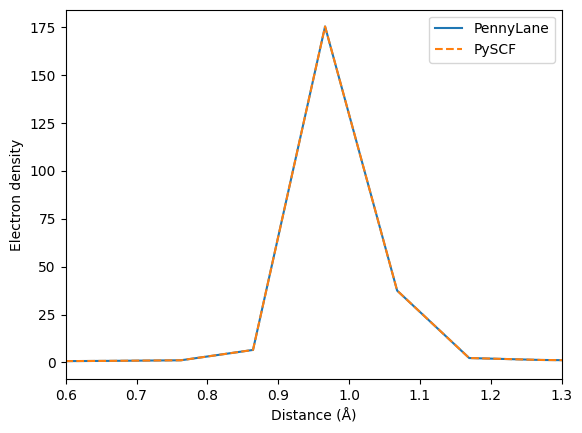

In [62]:
import matplotlib.pyplot as plt

plt.plot(grid[:, 0] / Ang2Bohr, density_grid, label="PennyLane")
plt.plot(grid[:, 0] / Ang2Bohr, density_grid_pyscf, label="PySCF", linestyle="dashed")
plt.xlim(0.6, 1.3)

plt.xlabel("Distance (Å)")
plt.ylabel("Electron density")
plt.legend()
plt.show()



##Maximum and Minimum values
Bond-critical points (BCP) Is the minimun value

In [64]:
#----------------- PySCF ---------------------------------------------------------

# Ensure that x has the same size as the density
x_pyscf = np.linspace(-2, 2, len(density_grid_pyscf))

# Calculate the Laplacian of the electron density for PySCF
dx = x_pyscf[1] - x_pyscf[0]  # Considering the spacing between the x points
laplacian_pyscf = laplacian_1d(density_grid_pyscf, dx)

# Calculate the first and second derivatives using np.gradient
drho_dx_pyscf = np.gradient(density_grid_pyscf, x_pyscf)
d2rho_dx2_pyscf = np.gradient(drho_dx_pyscf, x_pyscf)

# Find local maxima and minima
maxima_pyscf = argrelextrema(density_grid_pyscf, np.greater)[0]
minima_pyscf = argrelextrema(density_grid_pyscf, np.less)[0]

#----------------- PennyLane -----------------------------------------------------

# Ensure that x has the same size as the density
x_pennylane = np.linspace(-2, 2, len(density_grid))

# Calculate the Laplacian of the electron density for PennyLane
dx_pennylane = x_pennylane[1] - x_pennylane[0]  # Considering the spacing between the x points
laplacian_pennylane = laplacian_1d(density_grid, dx_pennylane)

# Calculate the first and second derivatives using np.gradient
drho_dx_pennylane = np.gradient(density_grid, x_pennylane)
d2rho_dx2_pennylane = np.gradient(drho_dx_pennylane, x_pennylane)

# Find local maxima and minima
maxima_pennylane = argrelextrema(density_grid, np.greater)[0]
minima_pennylane = argrelextrema(density_grid, np.less)[0]


#----------------- Graphs --------------------------------------
def print_critical_points(label, x_values, density_values):
    for idx in x_values:
        print(f"{label} at x = {x_pyscf[idx]:.3f} Å with density {density_values[idx]:.3f}")

# Print the critical points
print("PySCF Critical Points:")
print_critical_points("Local maximum", maxima_pyscf, density_grid_pyscf)
print_critical_points("Local minimum", minima_pyscf, density_grid_pyscf)

print("\nPennyLane Critical Points:")
print_critical_points("Local maximum", maxima_pennylane, density_grid)
print_critical_points("Local minimum", minima_pennylane, density_grid)


PySCF Critical Points:
Local maximum at x = 0.034 Å with density 0.349
Local maximum at x = 0.644 Å with density 175.172
Local minimum at x = 0.169 Å with density 0.324

PennyLane Critical Points:
Local maximum at x = 0.034 Å with density 0.349
Local maximum at x = 0.644 Å with density 175.172
Local minimum at x = 0.169 Å with density 0.324


##Laplacian

Laplacian of a 1D (density) function using the finite difference formula:


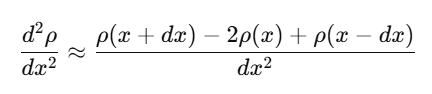


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Function to calculate the Laplacian (second derivative)

def laplacian_1d(rho_data, dx):
    laplacian_data = np.zeros_like(rho_data)

    # Calculate the second derivative in 1D using finite differences
    for i in range(1, len(rho_data) - 1):  #Avoid the edges
        laplacian_data[i] = (rho_data[i+1] - 2 * rho_data[i] + rho_data[i-1]) / dx**2

    return laplacian_data

#----------------- PySCF ---------------------------------------------------------
# Ensures that x has the same size as the density
x_pyscf = np.linspace(-2, 2, len(density_grid_pyscf))
# Calculate the electron density laplacian for PySCF
dx = x_pyscf[1] - x_pyscf[0]  # Considering the spacing between the points of x
laplacian_pyscf = laplacian_1d(density_grid_pyscf, dx)

# Find local maxima and minima
maxima_pyscf = argrelextrema(density_grid_pyscf, np.greater)[0]
minima_pyscf = argrelextrema(density_grid_pyscf, np.less)[0]

#----------------- PennyLane -----------------------------------------------------


x_pennylane = np.linspace(-2, 2, len(density_grid))

dx_pennylane = x_pennylane[1] - x_pennylane[0]
laplacian_pennylane = laplacian_1d(density_grid, dx_pennylane)
maxima_pennylane = argrelextrema(density_grid, np.greater)[0]
minima_pennylane = argrelextrema(density_grid, np.less)[0]

#----------------- Printing the Laplacian at Critical Points -------------------

print("\nLaplacian at Critical Points for PySCF Electron Density:")

print("\nPySCF Local Maxima Laplacian:")
for i in maxima_pyscf:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pyscf[i]:.5f}")

print("\nPySCF Local Minima Laplacian:")
for i in minima_pyscf:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pyscf[i]:5f}")


print("\nLaplacian at Critical Points for PennyLane Electron Density:")

print("\nPennylane Local Maxima Laplacian:")
for i in maxima_pennylane:
    print(f"x = {x_pennylane[i]:.3f} Å: Laplacian = {laplacian_pennylane[i]:.5f}")

print("\nPennylane Local Minima Laplacian:")
for i in minima_pennylane:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pennylane[i]:5f}")



#----------------- Differences between Laplacians and Δρ at Critical Points ------------------

print("\nDifferences between PySCF and PennyLane Laplacian at Critical Points:")

# Differences in local maxima
print("\nDifferences at Local Maxima:")
for i, max_pyscf in enumerate(maxima_pyscf):
    if i < len(maxima_pennylane):
        x_diff = abs(x_pyscf[max_pyscf] - x_pennylane[maxima_pennylane[i]])
        laplacian_diff = abs(laplacian_pyscf[max_pyscf] - laplacian_pennylane[maxima_pennylane[i]])
        rho_diff = abs(density_grid_pyscf[max_pyscf] - density_grid[maxima_pennylane[i]])
        print(f"Max Diff at x = {x_pyscf[max_pyscf]:.5f} Å: Δx = {x_diff:.5f} Å, ΔLaplacian = {laplacian_diff:.5f}, Δρ = {rho_diff:.5f}")

# Differences in local minima
print("\nDifferences at Local Minima:")
for i, min_pyscf in enumerate(minima_pyscf):
    if i < len(minima_pennylane):
        x_diff = abs(x_pyscf[min_pyscf] - x_pennylane[minima_pennylane[i]])
        laplacian_diff = abs(laplacian_pyscf[min_pyscf] - laplacian_pennylane[minima_pennylane[i]])
        rho_diff = abs(density_grid_pyscf[min_pyscf] - density_grid[minima_pennylane[i]])
        print(f"Min Diff at x = {x_pyscf[min_pyscf]:.5f} Å: Δx = {x_diff:.5f} Å, ΔLaplacian = {laplacian_diff:.5f}, Δρ = {rho_diff:.5f}")


Laplacian at Critical Points for PySCF Electron Density:

PySCF Local Maxima Laplacian:
x = 0.034 Å: Laplacian = -10.30770
x = 0.644 Å: Laplacian = -66643.63855

PySCF Local Minima Laplacian:
x = 0.169 Å: Laplacian = 9.927765

Laplacian at Critical Points for PennyLane Electron Density:

Pennylane Local Maxima Laplacian:
x = 0.034 Å: Laplacian = -10.30972
x = 0.644 Å: Laplacian = -66643.62944

Pennylane Local Minima Laplacian:
x = 0.169 Å: Laplacian = 9.929608

Differences between PySCF and PennyLane Laplacian at Critical Points:

Differences at Local Maxima:
Max Diff at x = 0.03390 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00201, Δρ = 0.00003
Max Diff at x = 0.64407 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00912, Δρ = 0.00002

Differences at Local Minima:
Min Diff at x = 0.16949 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00184, Δρ = 0.00000


#Dipole moment

In [66]:
from pyscf.scf.hf import dip_moment

print('Pyscf')
dipole_moment_pyscf = dip_moment(mol, rdm1_pyscf)

print('Pennylane')
dipole_moment_pennylane = dip_moment(mol, rdm1_ao)

print('diferrence: pennylane - pyscf')
difference_dipole = dipole_moment_pennylane - dipole_moment_pyscf
print(difference_dipole)

Pyscf
Dipole moment(X, Y, Z, Debye): -1.20800,  0.00000,  0.00000
Pennylane
Dipole moment(X, Y, Z, Debye): -1.20759,  0.00000, -0.00000
diferrence: pennylane - pyscf
[ 4.07833743e-04  0.00000000e+00 -5.42934720e-19]


#Mulliken pop

In [67]:
from pyscf.scf.hf import mulliken_pop

print('Pyscf')
mulliken_pop_pyscf = mulliken_pop(mol, rdm1_pyscf)

print('Pennylane')
mulliken_pop_pennylane = mulliken_pop(mol, rdm1_ao)

Pyscf
 ** Mulliken pop  **
pop of  0 H 1s            0.82691
pop of  1 F 1s            1.99922
pop of  1 F 2s            1.95167
pop of  1 F 2px           1.22352
pop of  1 F 2py           2.00000
pop of  1 F 2pz           1.99868
 ** Mulliken atomic charges  **
charge of    0H =      0.17309
charge of    1F =     -0.17309
Pennylane
 ** Mulliken pop  **
pop of  0 H 1s            0.82698
pop of  1 F 1s            1.99922
pop of  1 F 2s            1.95167
pop of  1 F 2px           1.22357
pop of  1 F 2py           2.00000
pop of  1 F 2pz           1.99856
 ** Mulliken atomic charges  **
charge of    0H =      0.17302
charge of    1F =     -0.17302


In [29]:
# The atomic charges are in the second part of the output tuple
charges_pyscf = mulliken_pop_pyscf[1]
charges_pennylane = mulliken_pop_pennylane[1]

# Calculate the difference between atomic charges
charge_differences = np.array(charges_pyscf) - np.array(charges_pennylane)

print("\nDifference between atomic charges:")
for i, diff in enumerate(charge_differences):
    print(f"Ato {i}: charge difference = {diff:.6f}")


Difference between atomic charges:
Ato 0: charge difference = 0.000071
Ato 1: charge difference = -0.000071


#Electrostatic potential

In [68]:
bohr_to_angstrom = 0.529177

def read_cube(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    # Skip the first 6 headers of the Cube file
    natoms = int(lines[2].split()[0])
    origin = np.array([float(x) for x in lines[2].split()[1:]])

    # Read grid dimensions
    nx, ny, nz = [int(lines[i].split()[0]) for i in range(3, 6)]
    grid_vectors = np.array([[float(x) for x in lines[i].split()[1:]] for i in range(3, 6)])

    # Calculate the coordinate grid
    x_vals = np.linspace(origin[0], origin[0] + grid_vectors[0, 0] * (nx - 1), nx)
    y_vals = np.linspace(origin[1], origin[1] + grid_vectors[1, 1] * (ny - 1), ny)
    z_vals = np.linspace(origin[2], origin[2] + grid_vectors[2, 2] * (nz - 1), nz)

    # Convert from Bohr to Ångströms
    x_vals *= bohr_to_angstrom
    y_vals *= bohr_to_angstrom
    z_vals *= bohr_to_angstrom

    # Read electrostatic potential data
    data_start = 6 + natoms  # Skip the atom lines
    values = np.array([float(v) for line in lines[data_start:] for v in line.split()])

    # Resize to 3D grid
    data = values.reshape((nx, ny, nz))

    return x_vals, y_vals, z_vals, data


In [69]:
cube_pyscf = tools.cubegen.mep(mol, "mep_pyscf.cube", rdm1_pyscf, resolution=0.1)
cube_pennylane = tools.cubegen.mep(mol, "mep_pennylane.cube", rdm1_ao, resolution=0.1)

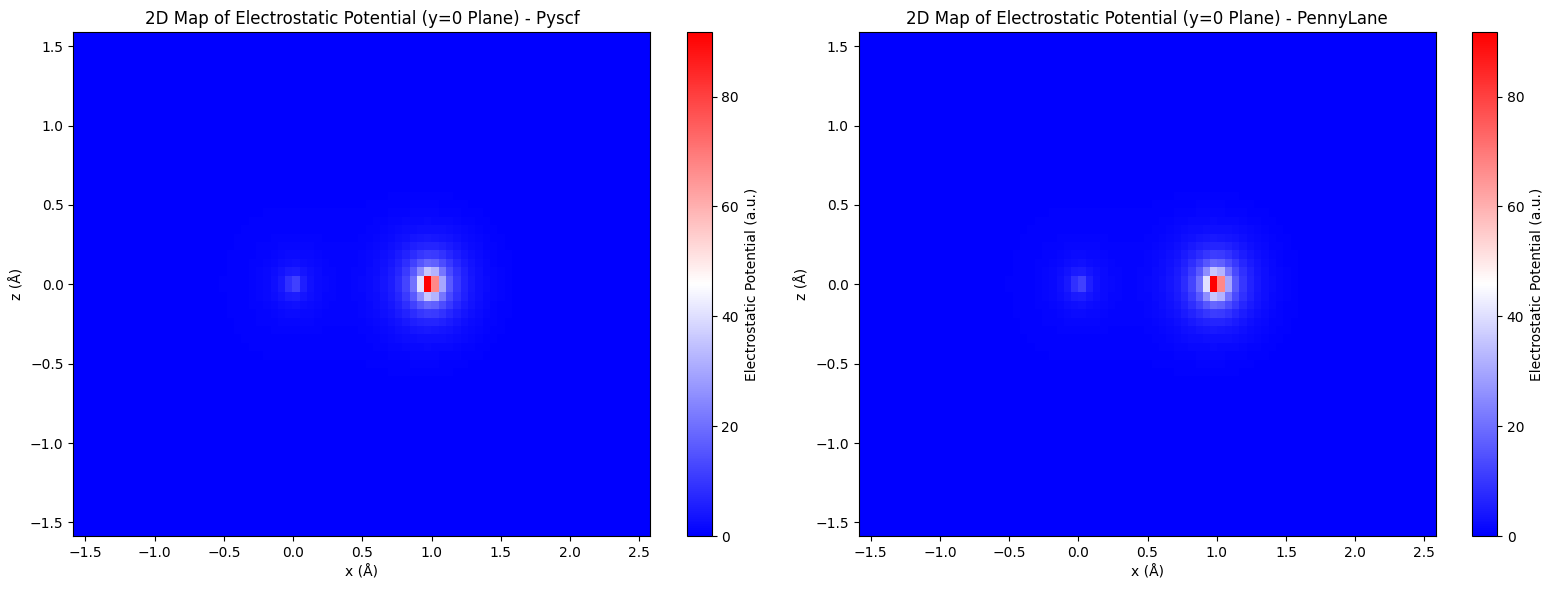

In [70]:
# Read data from the Cube file (Pyscf)
x_vals_1, y_vals_1, z_vals_1, data_1 = read_cube("mep_pyscf.cube")

# Take a cut in the middle of the grid (y plane = 0) for Pyscf
mid_y_1 = len(y_vals_1) // 2  # Central index
mep_2d_1 = data_1[:, mid_y_1, :]  # Grid slicing

# Read data from the Cube file (PennyLane)
x_vals_2, y_vals_2, z_vals_2, data_2 = read_cube("mep_pennylane.cube")

# Take a cut in the middle of the grid (y plane = 0) for PennyLane
mid_y_2 = len(y_vals_2) // 2  # Central index
mep_2d_2 = data_2[:, mid_y_2, :]  # Grid slicing

# Plotting the two heatmaps side by side
plt.figure(figsize=(16, 6))

# Subplot for Pyscf
plt.subplot(1, 2, 1)
plt.imshow(mep_2d_1.T, extent=[x_vals_1.min(), x_vals_1.max(), z_vals_1.min(), z_vals_1.max()],
           origin="lower", cmap="bwr", aspect="auto")
plt.colorbar(label="Electrostatic Potential (a.u.)")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("2D Map of Electrostatic Potential (y=0 Plane) - Pyscf")

# Subplot for PennyLane
plt.subplot(1, 2, 2)
plt.imshow(mep_2d_2.T, extent=[x_vals_2.min(), x_vals_2.max(), z_vals_2.min(), z_vals_2.max()],
           origin="lower", cmap="bwr", aspect="auto")
plt.colorbar(label="Electrostatic Potential (a.u.)")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("2D Map of Electrostatic Potential (y=0 Plane) - PennyLane")

plt.tight_layout()
plt.show()


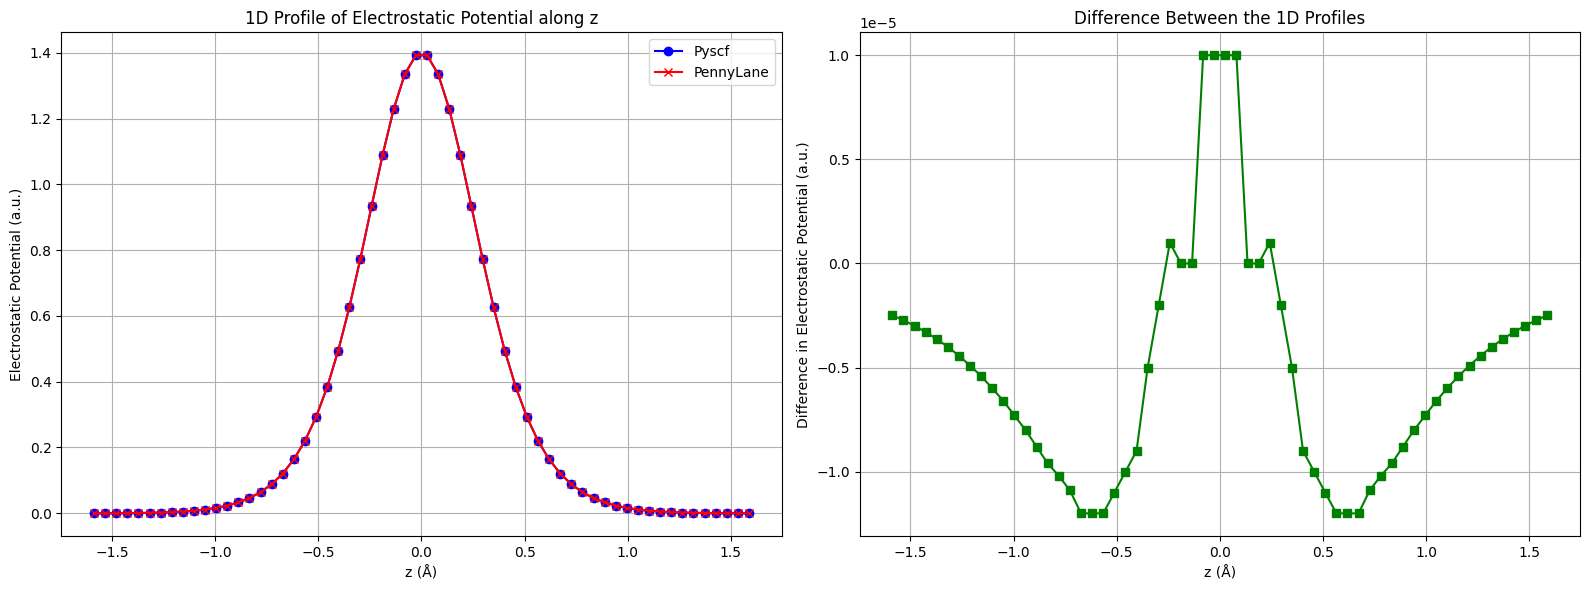

In [71]:
# Read data from the Cube file (Pyscf)
x_vals_1, y_vals_1, z_vals_1, data_1 = read_cube("mep_pyscf.cube")

# Extracting the 1D profile along the z-axis for Pyscf
ix_1 = len(x_vals_1) // 2
iy_1 = len(y_vals_1) // 2
mep_1d_1 = data_1[ix_1, iy_1, :]

# Read data from the Cube file (PennyLane)
x_vals_2, y_vals_2, z_vals_2, data_2 = read_cube("mep_pennylane.cube")

# Extracting the 1D profile along the z-axis for PennyLane
ix_2 = len(x_vals_2) // 2
iy_2 = len(y_vals_2) // 2
mep_1d_2 = data_2[ix_2, iy_2, :]

# Calculate the difference between the two profiles
mep_diff = mep_1d_1 - mep_1d_2

# Plotting the two profiles and their difference side by side
plt.figure(figsize=(16, 6))

# Subplot for the 1D profiles
plt.subplot(1, 2, 1)
plt.plot(z_vals_1, mep_1d_1, marker="o", label="Pyscf", color="b")
plt.plot(z_vals_2, mep_1d_2, marker="x", label="PennyLane", color="r")
plt.xlabel("z (Å)")
plt.ylabel("Electrostatic Potential (a.u.)")
plt.title("1D Profile of Electrostatic Potential along z")
plt.grid()
plt.legend()

# Subplot for the difference between the profiles
plt.subplot(1, 2, 2)
plt.plot(z_vals_1, mep_diff, marker="s", color="g")
plt.xlabel("z (Å)")
plt.ylabel("Difference in Electrostatic Potential (a.u.)")
plt.title("Difference Between the 1D Profiles")
plt.grid()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
